In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [5]:
from scipy.stats import gaussian_kde

In [2]:
data = pd.read_csv('data.csv')
data

,Standing Pedestrian Blockage,Standing Pedestrian Frequency,Parked Car Blockage,Parked Car Frequency,Parked Rickshaw Blockage,Parked Rickshaw Frequency,Parked CNG Blockage,Parked CNG Frequency,Walking Pedestrian Blockage,Walking Pedestrian Frequency
0,0.21,1.0,0.70,1.0,0.56,1.0,0.95,4.0,0.50,2
1,0.38,4.0,0.73,2.0,0.69,1.0,1.10,3.0,0.59,2
2,0.42,1.0,0.78,1.0,1.00,1.0,1.25,2.0,0.69,1
3,0.42,2.0,0.92,1.0,1.00,2.0,1.25,1.0,0.75,1
4,0.44,3.0,1.10,2.0,1.00,1.0,1.29,1.0,0.81,2
...,...,...,...,...,...,...,...,...,...,...
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,2
235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,3
236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,4
237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,1


In [ ]:
# Combine all features into a single array
all_features = data.values.flatten()

# Remove duplicates for KDE calculation
unique_features = np.unique(all_features)

In [3]:
# List of blockages and frequencies
blockages = [
    'Standing Pedestrian Blockage',
    'Parked Car Blockage',
    'Parked Rickshaw Blockage',
    'Parked CNG Blockage',
    'Walking Pedestrian Blockage'
]

frequencies = [
    'Standing Pedestrian Frequency',
    'Parked Car Frequency',
    'Parked Rickshaw Frequency',
    'Parked CNG Frequency',
    'Walking Pedestrian Frequency'
]

In [16]:
# Example: Plot for 'Standing Pedestrian Blockage'
# blockage = 'Standing Pedestrian Blockage'
# freq = 'Standing Pedestrian Frequency'

blockage = 'Parked Car Blockage'
freq = 'Parked Car Frequency'


In [21]:
# Extracting data
blockage_data = data[blockage]
frequency_data = data[freq]

# Clean the data: Remove NaNs and infinite values
valid_indices = np.isfinite(blockage_data) & np.isfinite(frequency_data)
blockage_data = blockage_data[valid_indices]
frequency_data = frequency_data[valid_indices]

# Kernel Density Estimate (KDE)
kde = gaussian_kde(blockage_data, weights=frequency_data)
x = np.linspace(min(blockage_data), max(blockage_data), 1000)
kde_density = kde(x)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)  # Adjust the number of components as needed
gmm.fit(blockage_data.values.reshape(-1, 1))
gmm_density = np.exp(gmm.score_samples(x.reshape(-1, 1)))


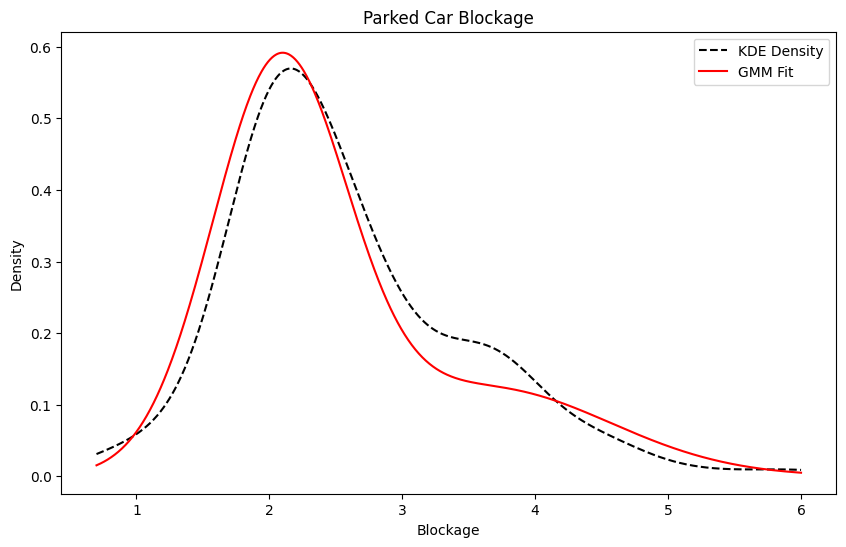

In [22]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, kde_density, 'k--', label='KDE Density')
plt.plot(x, gmm_density, 'r-', label='GMM Fit')
plt.title(blockage)
plt.xlabel('Blockage')
plt.ylabel('Density')
plt.legend()
plt.show()

In [23]:
def plot_gmm(blockage, freq, n_components=None):
    # Extracting data
    blockage_data = data[blockage]
    frequency_data = data[freq]

    # Clean the data: Remove NaNs and infinite values
    valid_indices = np.isfinite(blockage_data) & np.isfinite(frequency_data)
    blockage_data = blockage_data[valid_indices]
    frequency_data = frequency_data[valid_indices]

    # Kernel Density Estimate (KDE)
    kde = gaussian_kde(blockage_data, weights=frequency_data)
    x = np.linspace(min(blockage_data), max(blockage_data), 1000)
    kde_density = kde(x)

    # Fit Gaussian Mixture Model (GMM)
    if n_components is None:
        # Use model selection to determine the optimal number of components
        best_bic = np.inf
        best_gmm = None
        for n in range(1, 6):  # Test from 1 to 5 components
            gmm = GaussianMixture(n_components=n)
            gmm.fit(blockage_data.values.reshape(-1, 1))
            bic = gmm.bic(blockage_data.values.reshape(-1, 1))
            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
        gmm = best_gmm
    else:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(blockage_data.values.reshape(-1, 1))

    # Extract GMM parameters
    num_gaussians = gmm.n_components
    mixing_proportions = gmm.weights_
    means = gmm.means_.flatten()
    sds = np.sqrt(gmm.covariances_.flatten())

    # Print summary table
    summary_table = pd.DataFrame({
        'Factor': np.round(mixing_proportions, 3),
        'Mean': np.round(means, 2),
        'Standard Deviation': np.round(sds, 3)
    })
    summary_table.index += 1
    print("GMM Summary:")
    print(summary_table)

    # Compute GMM density
    gmm_density = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Plot histogram
    plt.hist(blockage_data, bins=30, density=True, alpha=0.5, color='grey', edgecolor='black', label='Histogram')
    
    # Plot KDE
    plt.plot(x, kde_density, 'b--', label='KDE Density')
    
    # Plot GMM
    plt.plot(x, gmm_density, 'r-', label='GMM Fit')
    
    plt.title(blockage)
    plt.xlabel('Blockage')
    plt.ylabel('Density')
    plt.legend()
    plt.show()



GMM Summary:
   Factor  Mean  Standard Deviation
1   0.185  1.27               0.235
2   0.262  3.21               0.478
3   0.263  2.02               0.290
4   0.016  5.75               0.250
5   0.275  0.72               0.234


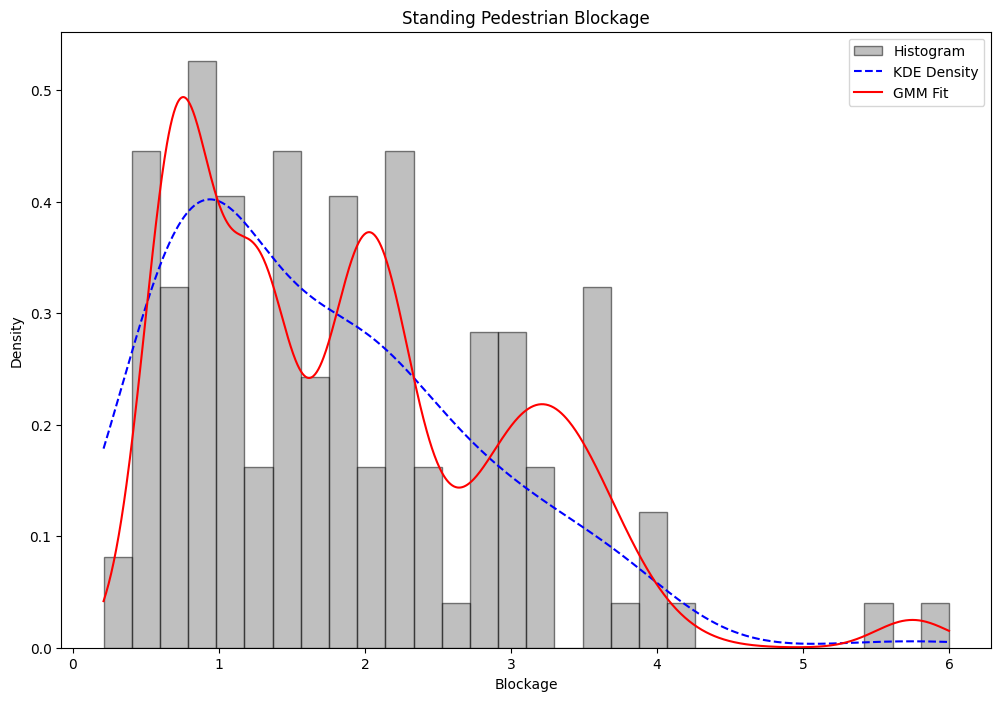

In [29]:
# Example usage: Plot for 'Standing Pedestrian Blockage'
plot_gmm('Standing Pedestrian Blockage', 'Standing Pedestrian Frequency', 5)

## With Random Seed

Number of components: 1, BIC: 401.5035366097427
Number of components: 2, BIC: 395.27448126716337
Number of components: 3, BIC: 400.3297461755871
Number of components: 4, BIC: 409.66373232826646
Number of components: 5, BIC: 417.0758063423891
GMM Summary:
   Factor  Mean  Standard Deviation
1   0.551  1.16               0.538
2   0.449  2.79               0.982


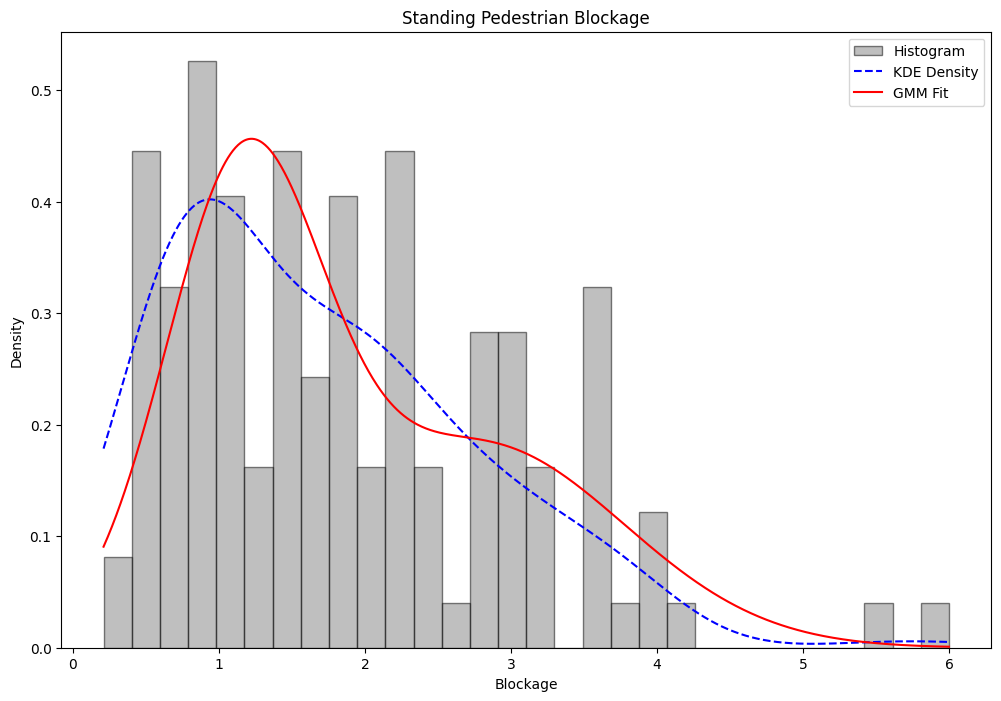

In [31]:
np.random.seed(42)

# Load the data
data = pd.read_csv('data.csv')

# List of blockages and frequencies
blockages = [
    'Standing Pedestrian Blockage',
    'Parked Car Blockage',
    'Parked Rickshaw Blockage',
    'Parked CNG Blockage',
    'Walking Pedestrian Blockage'
]

frequencies = [
    'Standing Pedestrian Frequency',
    'Parked Car Frequency',
    'Parked Rickshaw Frequency',
    'Parked CNG Frequency',
    'Walking Pedestrian Frequency'
]

def plot_gmm(blockage, freq, n_components=None):
    # Extracting data
    blockage_data = data[blockage]
    frequency_data = data[freq]

    # Clean the data: Remove NaNs and infinite values
    valid_indices = np.isfinite(blockage_data) & np.isfinite(frequency_data)
    blockage_data = blockage_data[valid_indices]
    frequency_data = frequency_data[valid_indices]

    # Kernel Density Estimate (KDE)
    kde = gaussian_kde(blockage_data, weights=frequency_data)
    x = np.linspace(min(blockage_data), max(blockage_data), 1000)
    kde_density = kde(x)

    # Fit Gaussian Mixture Model (GMM)
    if n_components is None:
        # Use model selection to determine the optimal number of components
        best_bic = np.inf
        best_gmm = None
        for n in range(1, 6):  # Test from 1 to 5 components
            gmm = GaussianMixture(n_components=n, random_state=42)
            gmm.fit(blockage_data.values.reshape(-1, 1))
            bic = gmm.bic(blockage_data.values.reshape(-1, 1))
            print(f"Number of components: {n}, BIC: {bic}")
            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
        gmm = best_gmm
    else:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(blockage_data.values.reshape(-1, 1))

    # Extract GMM parameters
    num_gaussians = gmm.n_components
    mixing_proportions = gmm.weights_
    means = gmm.means_.flatten()
    sds = np.sqrt(gmm.covariances_.flatten())

    # Print summary table
    summary_table = pd.DataFrame({
        'Factor': np.round(mixing_proportions, 3),
        'Mean': np.round(means, 2),
        'Standard Deviation': np.round(sds, 3)
    })
    summary_table.index += 1
    print("GMM Summary:")
    print(summary_table)

    # Compute GMM density
    gmm_density = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Plot histogram
    plt.hist(blockage_data, bins=30, density=True, alpha=0.5, color='grey', edgecolor='black', label='Histogram')
    
    # Plot KDE
    plt.plot(x, kde_density, 'b--', label='KDE Density')
    
    # Plot GMM
    plt.plot(x, gmm_density, 'r-', label='GMM Fit')
    
    plt.title(blockage)
    plt.xlabel('Blockage')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Example usage: Plot for 'Standing Pedestrian Blockage'
plot_gmm('Standing Pedestrian Blockage', 'Standing Pedestrian Frequency')

Number of components: 1, BIC: 471.9744555936361
Number of components: 2, BIC: 450.8175905583842
Number of components: 3, BIC: 455.7635296170464
Number of components: 4, BIC: 460.6009455683215
Number of components: 5, BIC: 474.72460335002773
GMM Summary:
   Factor  Mean  Standard Deviation
1   0.715  2.07               0.508
2   0.285  3.64               0.928


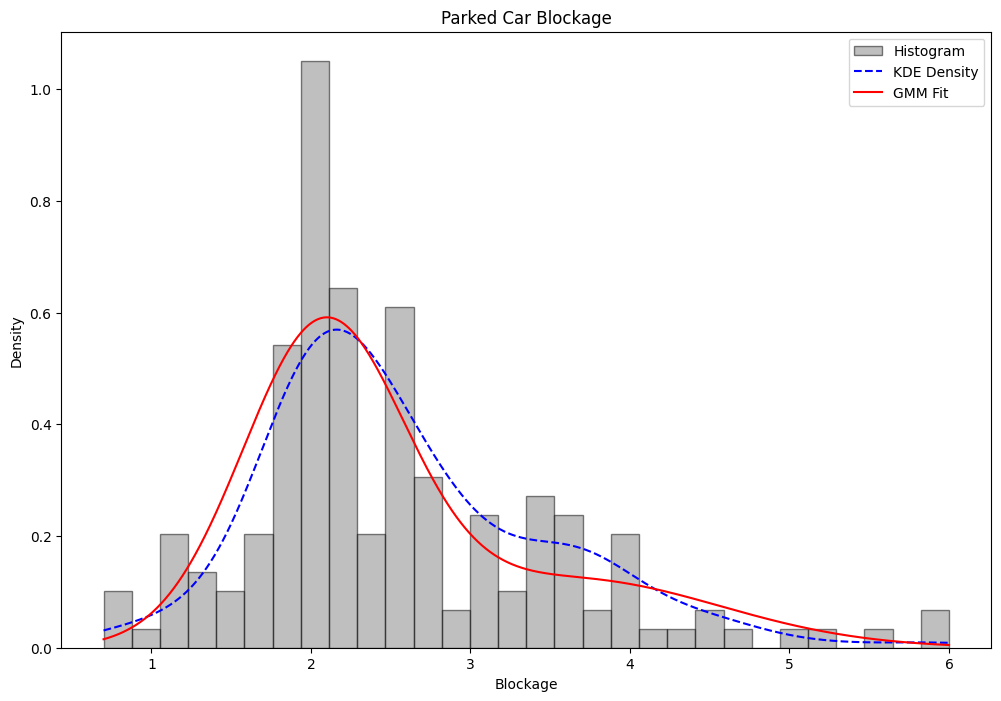

In [34]:
plot_gmm('Parked Car Blockage', 'Parked Car Frequency')

Number of components: 1, BIC: 428.96202988862905
Number of components: 2, BIC: 407.3561723131
Number of components: 3, BIC: 416.9135928874522
Number of components: 4, BIC: 427.95023416971355
Number of components: 5, BIC: 433.51204874619424
GMM Summary:
   Factor  Mean  Standard Deviation
1   0.715  1.74               0.516
2   0.285  3.43               0.881


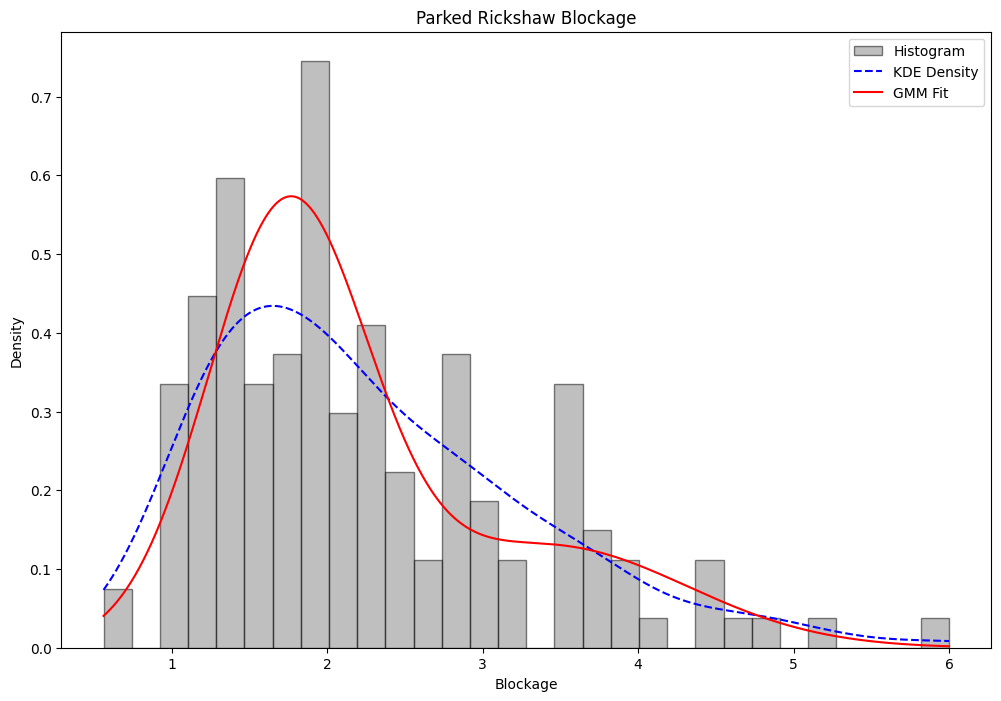

In [35]:
plot_gmm('Parked Rickshaw Blockage', 'Parked Rickshaw Frequency')

Number of components: 1, BIC: 134.12114919936607
Number of components: 2, BIC: 145.4106325750605
Number of components: 3, BIC: 152.20743881533002
Number of components: 4, BIC: 151.62138315886318
Number of components: 5, BIC: 147.54719300324572
GMM Summary:
   Factor  Mean  Standard Deviation
1     1.0  2.39               0.761


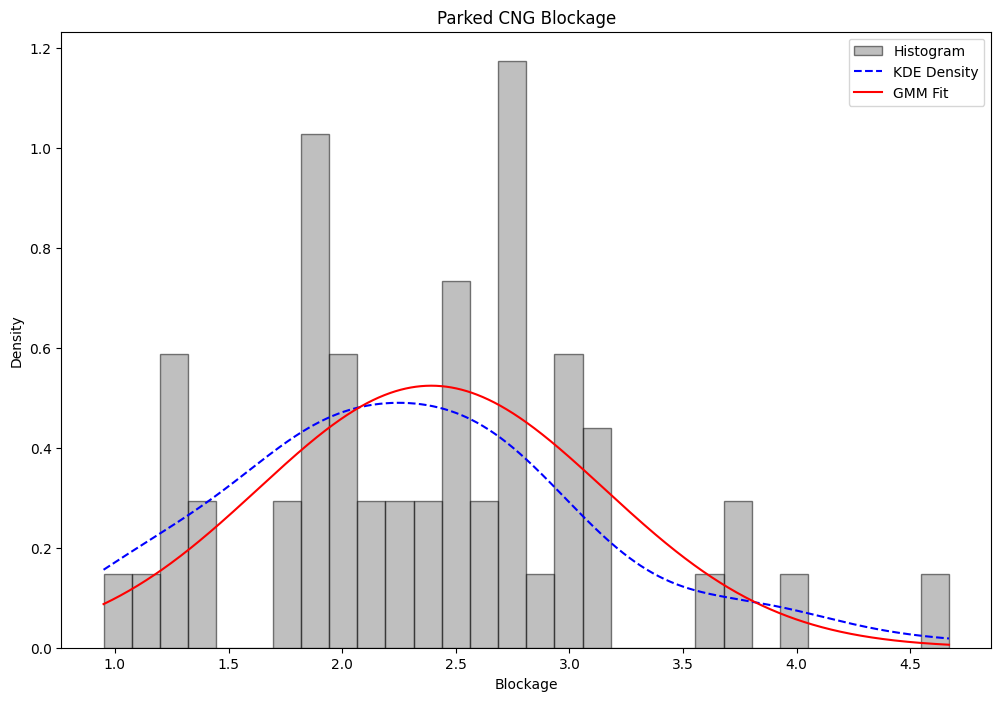

In [36]:
plot_gmm('Parked CNG Blockage', 'Parked CNG Frequency')